In [1]:
import sys
sys.path.append("../..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Jupyter stuff
# You may need to conda install seaborn matplotlib tqdm jupyterlab
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [4]:
import random
import numpy as np
from statistics import median

from tangle.core import Tangle, Transaction
from tangle.core.tip_selection import MaxDepthTipSelector
from tangle.theory import TempTransactionStore, TheoreticalNode


In [5]:
NUM_NODES = 1000
NUM_ROUNDS = 150
NODES_PER_ROUND = 10
VALIDATIONS_PER_ROUND = 10

DIST_STD_DEV = 100

PARTICLES_DEPTH = 50

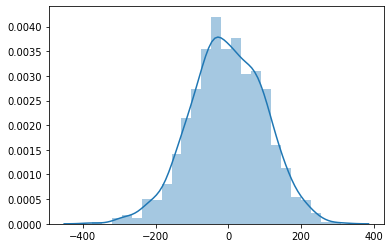

In [6]:
# Data
mu, sigma = 0, DIST_STD_DEV # mean and standard deviation
node_data = [np.array(x) for x in np.random.normal(mu, sigma, NUM_NODES)]
_ = sns.distplot(node_data)

In [7]:
# Tangle Initialization
tx_store = TempTransactionStore()
genesis = Transaction([])
# Initialize the genesis transaction with a number within the std dev interval
tx_store.save(genesis, np.array(random.uniform(-DIST_STD_DEV, DIST_STD_DEV)))
tangle = Tangle({genesis.id: genesis}, genesis.id)

In [8]:
# Results
num_txs = []     # Number of published transactions per round
consensus = []   # Value of consensus transaction per round (should converge to 0)

In [9]:
for r in tqdm(range(NUM_ROUNDS)):
    txs = []

    for _ in range(NODES_PER_ROUND):
        node_id = np.random.randint(NUM_NODES)
        tip_selector = MaxDepthTipSelector(tangle, PARTICLES_DEPTH)
        node = TheoreticalNode(tangle, tx_store, tip_selector, node_id, None, node_data[node_id])
        tx, tx_weights = node.create_transaction()

        if tx is not None:
            tx_store.save(tx, tx_weights)
            txs.append(tx)

    for tx in txs:
        tangle.add_transaction(tx)

    tip_selector = MaxDepthTipSelector(tangle, PARTICLES_DEPTH)
    # Use 'the average' node (data=0) for validation
    validation_node = TheoreticalNode(tangle, tx_store, tip_selector, 0, None, 0)
    reference_values = []
    for _ in range(VALIDATIONS_PER_ROUND):
        _, reference = validation_node.obtain_reference_params()
        reference_values.append(reference)

    num_txs.append(len(txs))
    consensus.append(reference_values)

100%|██████████| 150/150 [02:15<00:00,  1.11it/s]


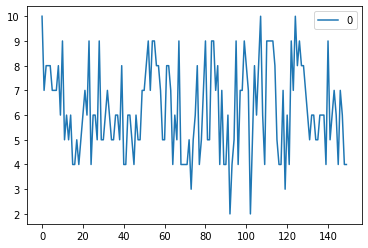

In [10]:
sns.lineplot(data=pd.DataFrame(num_txs))

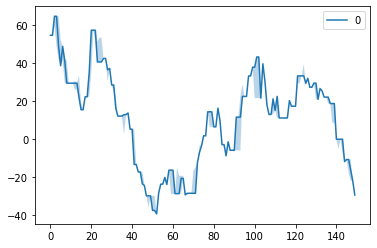

In [21]:
# Plot min max and median consensus values for each round
medians = pd.DataFrame([median(x) for x in consensus])
mins = [min(x) for x in consensus]
maxs = [max(x) for x in consensus]
ax = sns.lineplot(data=medians)
ax.fill_between(medians.index, mins, maxs, alpha=0.3)

In [24]:
median(consensus[-1]), min([abs(median(x)) for x in consensus])

(-29.530168497227685, 0.19297831232270912)